# Imagenet Example

This notebook demonstrates the iNNvestigate at hand of pre-trained ImageNet models, which requires more capable hardware than the [mnist-based example](./mnist_example.ipynb) (which we suggest you have a look first), but will follow the same pattern overall: First we will deal with all necessary imports, then load he model and some test data, and finally specify, create and run our analyzers before visualizing the analysis results. 

# Imports

In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
%matplotlib inline  

import numpy as np
import time
import imp
import os

import keras
import keras.backend
import keras.models

import innvestigate
import innvestigate.utils as iutils
import innvestigate.utils.tests.networks.base
import innvestigate.utils.visualizations as ivis

eutils = imp.load_source("utils", "../utils.py")
imgnetutils = imp.load_source("utils_imagenet", "../utils_imagenet.py")

Using TensorFlow backend.


# Model

In this demo, we load a VGG16-model trained on ImageNet, which uses ReLU activation layers. As in our MNIST demo, we use a model using the network's softmax output for inferrence and the immediately preceding logit output for analysis purposes.

In [3]:
# Parameter
netname = "vgg16"
pattern_type = "relu"

In [4]:
# Build Model
tmp = getattr(innvestigate.applications.imagenet, netname)
net = tmp(load_weights=True, load_patterns=pattern_type)

model = keras.models.Model(inputs=net["in"], outputs=net["out"])
model.compile(optimizer="adam", loss="categorical_crossentropy")
modelp = keras.models.Model(inputs=net["in"], outputs=net["sm_out"])
modelp.compile(optimizer="adam", loss="categorical_crossentropy")

# Handle input depending on model and backend
channels_first = keras.backend.image_data_format() == "channels_first"
color_conversion = "BGRtoRGB" if net["color_coding"] == "BGR" else None

A local file was found, but it seems to be incomplete or outdated because the sha256 file hash does not match the original value of 847a05e1cb2d689d56170cc1998a2d042d5624c6e58f19ac916b5d70555c41ad0 so we will re-download the data.
553385984/553380098 [==============================] - 19s 0us/step


# Data

Next, load some pre-selected example images from the ImageNet test set and prepare them to fit the input size of the loaded model. To analyze your own example (from the ImageNet test set -- it must for now match the ImageNet image name to label mapping) images, just add them to `innvestigate/examples/images`.

In [5]:
# Get some example test set images.
images, label_to_class_name = eutils.get_imagenet_data(
    net["image_shape"][0])

# Analysis

Next, we will set up a list of analysis methods by preparing tuples containing the methods' string identifiers used by `innvestigate.analyzer.create_analyzer(...)`, some optional parameters, a post processing choice for visualizing the computed analysis and a title for the figure to render. Analyzers can be deactivated by simply commenting the corresponding lines, or added by creating a new tuple as below.

For a full list of methods refer to the dictionary `investigate.analyzer.analyzers`.

Note: Should you run into resource trouble, e.g. you are running that notebook on a notebook without or with only limited GPU memory, consider deactivating one or more analyzers by commenting the corresponding lines in the next cell, or execute this notebook on a CPU (in that case, go and grab a coffee while waiting for the analyzers to finish).

In [6]:
# Determine analysis methods and properties
patterns = net["patterns"]
# Methods we use and some properties.
methods = [
    # NAME                    OPT.PARAMS                POSTPROC FXN                TITLE
    # Show input.
    ("input",                 {},                       imgnetutils.image,         "Input"),

    # Function
    ("gradient",              {},                       imgnetutils.graymap,       "Gradient"),
    ("smoothgrad",            {"noise_scale": 50},      imgnetutils.graymap,       "SmoothGrad"),
    ("integrated_gradients",  {},                       imgnetutils.graymap,       "Integrated Gradients"),

    # Signal
    ("deconvnet",             {},                       imgnetutils.bk_proj,       "Deconvnet"),
    ("guided_backprop",       {},                       imgnetutils.bk_proj,       "Guided Backprop",),
    ("pattern.net",           {"patterns": patterns},   imgnetutils.bk_proj,       "PatternNet"),

    # Interaction
    ("pattern.attribution",   {"patterns": patterns},   imgnetutils.heatmap,       "PatternAttribution"),
    ("lrp.z_baseline",        {},                       imgnetutils.heatmap,       "Gradient*Input"),
    ("lrp.z",                 {},                       imgnetutils.heatmap,       "LRP-Z"),
    ("lrp.epsilon",           {"epsilon": 1},           imgnetutils.heatmap,       "LRP-Epsilon"),
    ("lrp.sequential_preset_a_flat",{"epsilon": 1},     imgnetutils.heatmap,       "LRP-PresetAFlat"),
    ("lrp.sequential_preset_b_flat",{"epsilon": 1},     imgnetutils.heatmap,       "LRP-PresetBFlat"),
    ]

The main loop below will now instantiate the analyzer objects based on the loaded/trained model and the analyzers' parameterizations above and compute the analyses.

In [7]:
# Create analyzers.
analyzers = []
print('Creating analyzer instances. ')
for method in methods:
    try:
        analyzer = innvestigate.create_analyzer(method[0],   # analysis method identifier
                                                model,       # model without softmax output
                                                **method[1]) # optional analysis parameters
    
    #some analyzers do not fully support all networks yet.
    except innvestigate.NotAnalyzeableModelException:
        analyzer = None 
    analyzers.append(analyzer)
    
print('Running analyses. ')
# Run analyses
analysis = np.zeros([len(images), len(analyzers)]+net["image_shape"]+[3])
text = []
for i, (image, y) in enumerate(images):
    print ('Image {}: '.format(i), end='')
    t_start = time.time()
    image = image[None, :, :, :]
    # Predict label.
    x = imgnetutils.preprocess(image, net)
    presm = model.predict_on_batch(x)[0] #forward pass without softmax
    prob = modelp.predict_on_batch(x)[0] #forward pass with softmax
    y_hat = prob.argmax()

    # Save prediction info:
    text.append(("%s" %label_to_class_name[y],    # ground truth label
                 "%.2f" %presm.max(),             # pre-softmax logits
                 "%.2f" % prob.max(),             # probabilistic softmax output  
                 "%s" %label_to_class_name[y_hat] # predicted label
                ))

    for aidx, analyzer in enumerate(analyzers):
        is_input_analyzer = methods[aidx][0] == "input"
        
        # Analyze.
        if analyzer:
            a = analyzer.analyze(image if is_input_analyzer else x)

            # Postprocess.
            if not np.all(np.isfinite(a)):
                print("Image %i, analysis of %s not finite: nan %s inf %s" %
                        (i, methods[aidx][3],
                        np.any(np.isnan(a)), np.any(np.isinf(a))))
            if not is_input_analyzer:
                a = imgnetutils.postprocess(a, color_conversion, channels_first)
            a = methods[aidx][2](a)
        else:
            a = np.zeros_like(image)
        analysis[i, aidx] = a[0]
    t_elapsed = time.time() - t_start
    print('{:.4f}s '.format(t_elapsed))

Creating analyzer instances. 
Running analyses. 
Image 0: 28.9717s 
Image 1: 1.0056s 
Image 2: 0.9516s 
Image 3: 0.9430s 
Image 4: 0.9449s 
Image 5: 1.0045s 
Image 6: 1.0289s 


You might have noticed that the analysis times for `Image 0` are substantially longer for all methods, compared to the follow-ups. Each analyzer manages a computational graph it attaches to the analyzed model. Upon first execution, the analyzer needs to build that graph, which can take some time. Each consecutive analysis on the same model though is almost instant.

Next, we visualize the analysis results.

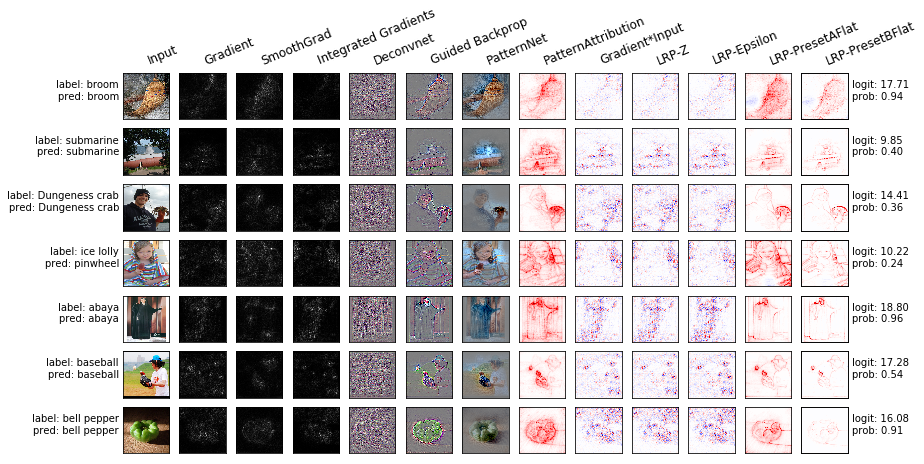

In [8]:
# Plot the analysis.

grid = [[analysis[i, j] for j in range(analysis.shape[1])]
        for i in range(analysis.shape[0])]  
label, presm, prob, pred = zip(*text)
row_labels_left = [('label: {}'.format(label[i]),'pred: {}'.format(pred[i])) for i in range(len(label))]
row_labels_right = [('logit: {}'.format(presm[i]),'prob: {}'.format(prob[i])) for i in range(len(label))]
col_labels = [''.join(method[3]) for method in methods]

eutils.plot_image_grid(grid, row_labels_left, row_labels_right, col_labels)

This figure shows the analysis regarding the *actually predicted* class as computed by the selected analyzers. Each column shows the visualized results for different analyzers and each row shows the analyses wrt to one input sample. To the left of each row, the ground truth label `label` and the predicted label `pred` are show. To the right, the model's probabilistic (softmax) output is shown as `prob` and the logit output just before the terminating softmax layer as `logit`. Note that all analyses have been performed based on the logit output (layer).

Also have a look at our [MNIST example](./mnist_example.ipynb)!